In [3]:
import os
import random

from collections import OrderedDict
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torchvision.models as models


from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box, compute_ts_road_map, compute_ats_bounding_boxes

from anchors import get_bbox_gt, batched_coor_threat_updated, get_coordinate


from resnet import resnet18
from obj_model import BoundingBox

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! unzip  -nq '/content/drive/My Drive/student_data.zip' -d '/content/drive/My Drive/data/'

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# construct anchor boxes
def get_anchor_boxes(scaleX=[100, 70, 50, 20], scaleY=[25, 20, 15, 5]):
    widths = torch.tensor(scaleX)
    heights = torch.tensor(scaleY)
    ref_boxes = []
    for x in range(800):
        for y in range(800):
            x_r = widths + x
            y_r = heights + y
            x_l = torch.tensor([x, x, x, x])
            y_l = torch.tensor([y, y, y, y])
            x_r = x_r.unsqueeze(0)
            y_r = y_r.unsqueeze(0)
            x_l = x_l.unsqueeze(0)
            y_l = y_l.unsqueeze(0)
            ref_box = torch.cat((x_l, y_l, x_r, y_r))
            ref_box = ref_box.permute((1,0))
            ref_boxes.append(ref_box)

    anchor_boxes = torch.stack(ref_boxes).view(-1,4).type(torch.double)
    
    return anchor_boxes

In [6]:
def nms(boxes, scores, iou_threshold):
    # type: (Tensor, Tensor, float)
    """
    Performs non-maximum suppression (NMS) on the boxes according
    to their intersection-over-union (IoU).
    NMS iteratively removes lower scoring boxes which have an
    IoU greater than iou_threshold with another (higher scoring)
    box.
    Parameters
    ----------
    boxes : Tensor[N, 4])
        boxes to perform NMS on. They
        are expected to be in (x1, y1, x2, y2) format
    scores : Tensor[N]
        scores for each one of the boxes
    iou_threshold : float
        discards all overlapping
        boxes with IoU > iou_threshold
    Returns
    -------
    keep : Tensor
        int64 tensor with the indices
        of the elements that have been kept
        by NMS, sorted in decreasing order of scores
    """
    return torch.ops.torchvision.nms(boxes, scores, iou_threshold)



def batched_coor_threat_updated(ite, predicted_offsets, anchor_boxes, target, gt_classes, batch_sz, nms_threshold=0.1, plot=False):
  # predicted offsets, target_offests, coor_in_meter
    batch_coor = []
    batched_threat_sum=0
    original_anchor = anchor_boxes.clone()
    original_predicted_offsets = predicted_offsets.clone()
    original_gt_classes = gt_classes.clone()

    for i in range(batch_sz):
        anchor_boxes = original_anchor
        predicted_offsets = original_predicted_offsets[i]
        if i == 0:
          cur_target = torch.from_numpy(target[0])
        else:
          cur_target = torch.from_numpy(target[1])
    
        gt_classes = original_gt_classes[i]

        inds = (gt_classes != 0)
        anchor_boxes = anchor_boxes[inds]
        predicted_offsets = predicted_offsets[inds]
        gt_classes = gt_classes[inds]


        delta_x = predicted_offsets[:,0]
        delta_y = predicted_offsets[:,1]
        delta_scaleX = predicted_offsets[:,2]
        delta_scaleY = predicted_offsets[:,3]

        gt_widths = anchor_boxes[:, 2] - anchor_boxes[:, 0]
        gt_heights = anchor_boxes[:, 3] - anchor_boxes[:, 1]
        gt_center_x = anchor_boxes[:, 0] + 0.5 * gt_widths
        gt_center_y = anchor_boxes[:, 1] + 0.5 * gt_heights

        ex_width = gt_widths / torch.exp(delta_scaleX)
        ex_height = gt_heights / torch.exp(delta_scaleY)
        ex_center_x = gt_center_x - delta_x*ex_width
        ex_center_y = gt_center_y - delta_y*ex_height

        ex1 = ex_center_x - 0.5*ex_width
        ex2 = ex_center_x + 0.5*ex_width
        ey1 = ex_center_y - 0.5*ex_height
        ey2 = ex_center_y + 0.5*ex_height


        pred_boxes = torch.cat([ex1.unsqueeze(0), ey1.unsqueeze(0), ex2.unsqueeze(0), ey2.unsqueeze(0)], dim=0).permute(1,0)
        pred_boxes = pred_boxes.type(torch.float32)
        gt_classes = gt_classes.type(torch.float32)
        cur_target = cur_target.type(torch.float32)
   
        inds = nms(pred_boxes, gt_classes, nms_threshold)
        pred_boxes = pred_boxes[inds]
        coordinate_list = []

        for box in pred_boxes:
            x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
            x1 = (x1-400)/10
            x2 = (x2-400)/10
            y1 = (y1-400)/-10
            y2 = (y2-400)/-10
            width = abs(x1 - x2)
            height = abs(y1 - y2)
            coordinate_list.append(torch.tensor([x2, x2, x1, x1, y2, y1, y2, y1]).view(-1, 4))
            
        coordinate_list = torch.stack(coordinate_list)
        
        
        print('batch {}'.format(i))
        print(coordinate_list)
        print('current Threat Score {}'.format( compute_ats_bounding_boxes(coordinate_list, cur_target) ))
        
        batched_threat_sum += compute_ats_bounding_boxes(coordinate_list, cur_target)
        batch_coor.append(coordinate_list)
        #visActual(cur_target, ite,i)
    return batch_coor, batched_threat_sum


In [7]:
def get_targets(target, sample):
    device = 'cpu'
    map_sz = 800
    batched_preds = []
    batched_offsets = []
    for t, s in zip(target, sample):
        bboxes = t['bounding_box'].to(device)
        gt_classes, gt_offsets = get_bbox_gt(bboxes, t['category'].to(device), get_anchor_boxes().to(device), map_sz, device)
        batched_preds.append(gt_classes)
        batched_offsets.append(gt_offsets)

    class_targets = torch.stack(batched_preds)
    box_targets = torch.stack(batched_offsets)

    return class_targets, box_targets

In [8]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

image_folder = '/content/drive/My Drive/data/data'
annotation_csv = '/content/drive/My Drive/data/data/annotation.csv'

image_folder = '../data'
annotation_csv = '../data/annotation.csv'

In [9]:
labeled_scene_index = np.arange(106, 134)

train_index = np.arange(106,108)
val_index = np.arange(128,130)

In [10]:
transform = torchvision.transforms.ToTensor()

labeled_trainset = LabeledDataset(
    image_folder=image_folder,
    annotation_file=annotation_csv,
    scene_index=train_index,
    transform=transform,
    extra_info=False
    )

labeled_valset = LabeledDataset(
    image_folder=image_folder,
    annotation_file=annotation_csv,
    scene_index=val_index,
    transform=transform,
    extra_info=False
    )

trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
valloader = torch.utils.data.DataLoader(labeled_valset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [11]:
class BoundingBox(nn.Module):
    def __init__(self):
        super().__init__()
        ############################################################################
        self.encoder = resnet18()
        self.classifier = nn.Conv2d(512, 10, kernel_size=3, padding=1, bias=False)
        
        self.input_shape = (800,800)
        self.relu = nn.ReLU(inplace=True) 
        self.bn1 = nn.BatchNorm2d(16, momentum=0.01)
        self.classifier1 = nn.Conv2d(3, 18, kernel_size=3, padding=1, bias=False)
        self.regressor = nn.Conv2d(10, 4*4, kernel_size=3, padding=1, bias=False)
        self.pred = nn.Conv2d(10, 4*9, kernel_size=3, padding=1, bias=False)

    def forward(self, x):

        features = []
        for im in x:
          feature_list = []
          for i in im:
            feat = self.classifier1(i.view(-1,3,256,306))
            feature_list.append(feat)

          feat = torch.cat(feature_list)
          features.append(feat)

        x = torch.cat(features)
        x = self.encoder(x)
        #print('after classifier, x dimension {}'.format(x.shape))
        x = self.classifier(x)
        #print('after classifier, x dimension {}'.format(x.shape))
        x = F.interpolate(x, size=self.input_shape, mode='bilinear', align_corners=False)
        #print('after interpolate, x dimension {}'.format(x.shape))
        pred_x = self.pred(x)
        box_x = self.regressor(x)
        #print('pred_x shape {}, box_x shape {}'.format(pred_x.shape, box_x.shape))
        return pred_x, box_x


model = BoundingBox().double().to(device)

In [0]:
#model.load_state_dict(torch.load('bbox_1epoch.pt', map_location=device))

In [12]:
def get_coordinate(predicted_offsets, anchor_boxes, target, gt_classes, nms_threshold=0.1, plot=False):

    cur_target = torch.from_numpy(target)

    #gt_classes = original_gt_classes

    inds = (gt_classes != 0)
    anchor_boxes = anchor_boxes[inds]
    predicted_offsets = predicted_offsets[inds]
    gt_classes = gt_classes[inds]


    delta_x = predicted_offsets[:,0]
    delta_y = predicted_offsets[:,1]
    delta_scaleX = predicted_offsets[:,2]
    delta_scaleY = predicted_offsets[:,3]

    gt_widths = anchor_boxes[:, 2] - anchor_boxes[:, 0]
    gt_heights = anchor_boxes[:, 3] - anchor_boxes[:, 1]
    gt_center_x = anchor_boxes[:, 0] + 0.5 * gt_widths
    gt_center_y = anchor_boxes[:, 1] + 0.5 * gt_heights

    ex_width = gt_widths / torch.exp(delta_scaleX)
    ex_height = gt_heights / torch.exp(delta_scaleY)
    ex_center_x = gt_center_x - delta_x*ex_width
    ex_center_y = gt_center_y - delta_y*ex_height

    ex1 = ex_center_x - 0.5*ex_width
    ex2 = ex_center_x + 0.5*ex_width
    ey1 = ex_center_y - 0.5*ex_height
    ey2 = ex_center_y + 0.5*ex_height


    pred_boxes = torch.cat([ex1.unsqueeze(0), ey1.unsqueeze(0), ex2.unsqueeze(0), ey2.unsqueeze(0)], dim=0).permute(1,0)
    pred_boxes = pred_boxes.type(torch.float32)
    gt_classes = gt_classes.type(torch.float32)
    cur_target = cur_target.type(torch.float32)

    inds = nms(pred_boxes, gt_classes, nms_threshold)
    pred_boxes = pred_boxes[inds]
    coordinate_list = []
    
    for box in pred_boxes:
      x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
      x1 = (x1-400)/10
      x2 = (x2-400)/10
      y1 = (y1-400)/-10
      y2 = (y2-400)/-10
      width = abs(x1 - x2)
      height = abs(y1 - y2)
      coordinate_list.append(torch.tensor([x2, x2, x1, x1, y2, y1, y2, y1]).view(-1, 4))
    coordinate_list = torch.stack(coordinate_list)
    
    return coordinate_list

In [0]:
batch_sz = 2

model.train()

threat_scores = []
model.eval()
for i, (sample, target, road_image) in enumerate(trainloader):
  samples = torch.stack(sample).to(device).double()
  class_target, box_target = get_targets(target, sample)
  print('class_target shape {}'.format(class_target.shape))
  print('box_target shape {}'.format(box_target.shape))
  out_pred, out_bbox = model(samples)

  print('out_pred shape {}'.format(out_pred.shape))
  print('out_bbox shape {}'.format(out_bbox.shape))
  out_bbox = out_bbox.view(batch_sz, -1, 4)
  print('out_bbox shape {}'.format(out_bbox.shape))

  for t in range(batch_sz):
    print('target coordinates: {}'.format(target[t]['bounding_box'].numpy()))
    pred_coor = get_coordinate(out_bbox[t].to('cpu'), get_anchor_boxes(), target[t]['bounding_box'].numpy(), class_target[t], nms_threshold=0.1, plot=False)
    print('pred_coor: {}'.format(pred_coor))
    
    threat_scores.append( compute_ats_bounding_boxes(pred_coor, target[t]['bounding_box']).item() )


In [0]:


pred_coor = get_coordinate(out_bbox[t].to('cpu'), get_anchor_boxes(), target[0]['bounding_box'].numpy(), class_target[0], nms_threshold=0.1, plot=False)


In [54]:
compute_ats_bounding_boxes(pred_coor, target[0]['bounding_box']  )

tensor(0.5176)

In [59]:
print(pred_coor.shape)
print(target[0]['bounding_box'].shape)

torch.Size([21, 2, 4])
torch.Size([20, 2, 4])


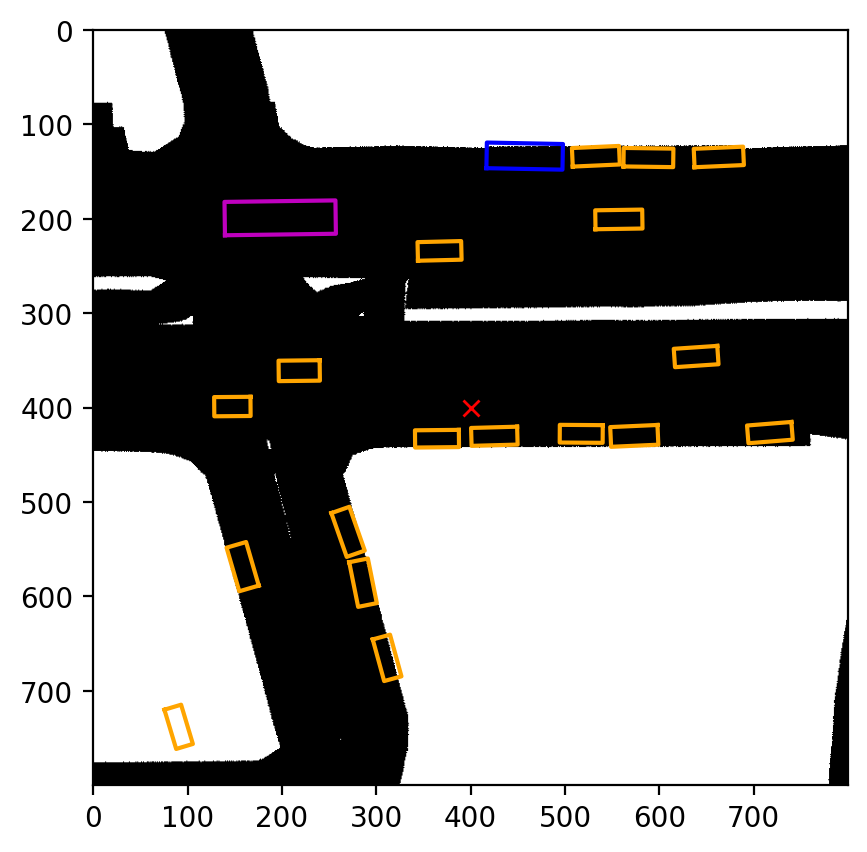

In [57]:
fig, ax = plt.subplots()
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary');
# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
  draw_box(ax, bb, color=color_list[target[0]['category'][i]])

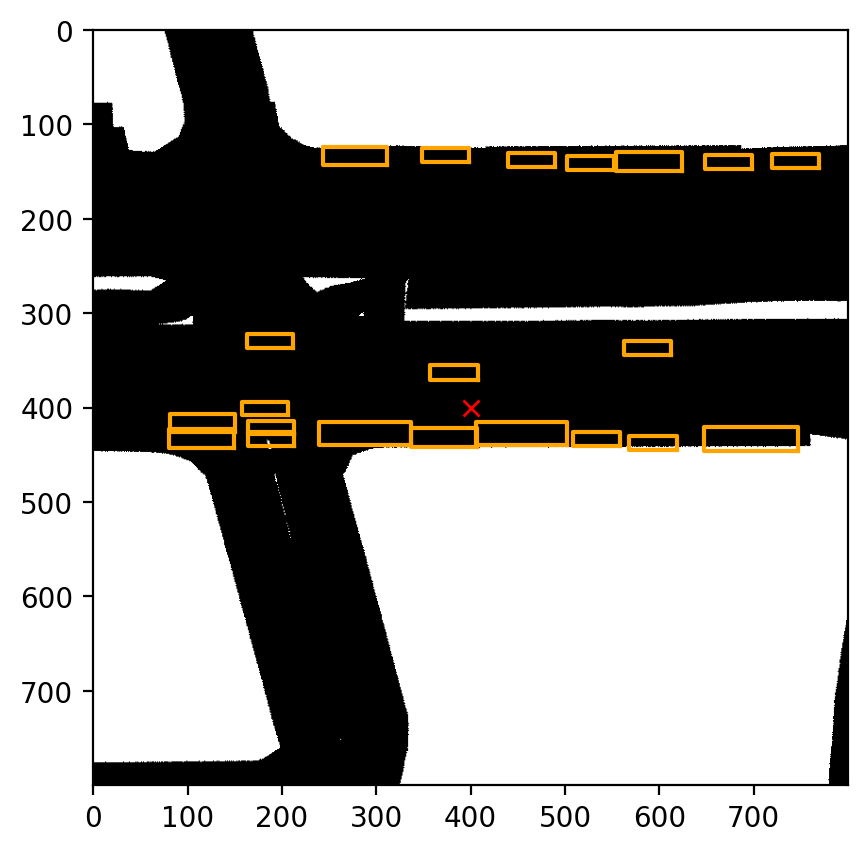

In [61]:
fig, ax = plt.subplots()
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary');
# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(pred_coor):
    # You can check the implementation of the draw box to understand how it works 
  draw_box(ax, bb, color='orange')

In [63]:
threat_scores

[0.5207352638244629,
 0.6833421587944031,
 0.027851693332195282,
 0.5597348809242249,
 0.428225040435791,
 0.5723174810409546,
 0.07675804197788239,
 0.027479559183120728,
 0.25625333189964294,
 0.6194784641265869,
 0.10927797853946686,
 0.33011722564697266,
 0.13587360084056854,
 0.5517733693122864,
 0.03856578841805458,
 0.6286017894744873,
 0.09669627994298935,
 0.6833421587944031,
 0.35562753677368164,
 0.04204363748431206,
 0.042463794350624084,
 0.1284371018409729,
 0.5744871497154236,
 0.395795613527298,
 0.6180353164672852,
 0.054323408752679825,
 0.3626263737678528,
 0.5038140416145325,
 0.4811040163040161,
 0.5824900269508362]

In [13]:
sample, target, road_image = iter(trainloader).next()

print(target[0]['bounding_box'])
print(target[0]['bounding_box'].shape)

print(target[0]['category'])
print(target[0]['category'].shape)


tensor([[[  1.3773,   1.3746,  -3.4016,  -3.4042],
         [  8.1791,   6.3725,   8.1853,   6.3787]],

        [[-20.6357, -20.6385, -25.2146, -25.2174],
         [  1.0726,  -0.8569,   1.0785,  -0.8510]],

        [[ 18.2048,  18.2019,  13.6259,  13.6230],
         [  4.4794,   2.4928,   4.4853,   2.4988]],

        [[  0.4752,   0.4390,  -4.1908,  -4.2270],
         [ -2.2197,  -4.1309,  -2.1322,  -4.0434]]], dtype=torch.float64)
torch.Size([4, 2, 4])
tensor([2, 2, 2, 2])
torch.Size([4])


In [15]:
torch.ones(len(target[0]['category']))

tensor([1., 1., 1., 1.])

In [0]:
model.load_state_dict(torch.load('../code/PT_FILES/bbox_1epoch.pt', map_location=device))

<All keys matched successfully>

In [0]:
def draw_box(ax, corners, color):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    # the corners are in meter and time 10 will convert them in pixels
    # Add 400, since the center of the image is at pixel (400, 400)
    # The negative sign is because the y axis is reversed for matplotlib
    ax.plot(point_squence.transpose(0,1).numpy()[0] * 10 + 400, -point_squence.transpose(0,1).numpy()[1] * 10 + 400, color=color)

# The center of image is 400 * 400

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7efe46521588>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


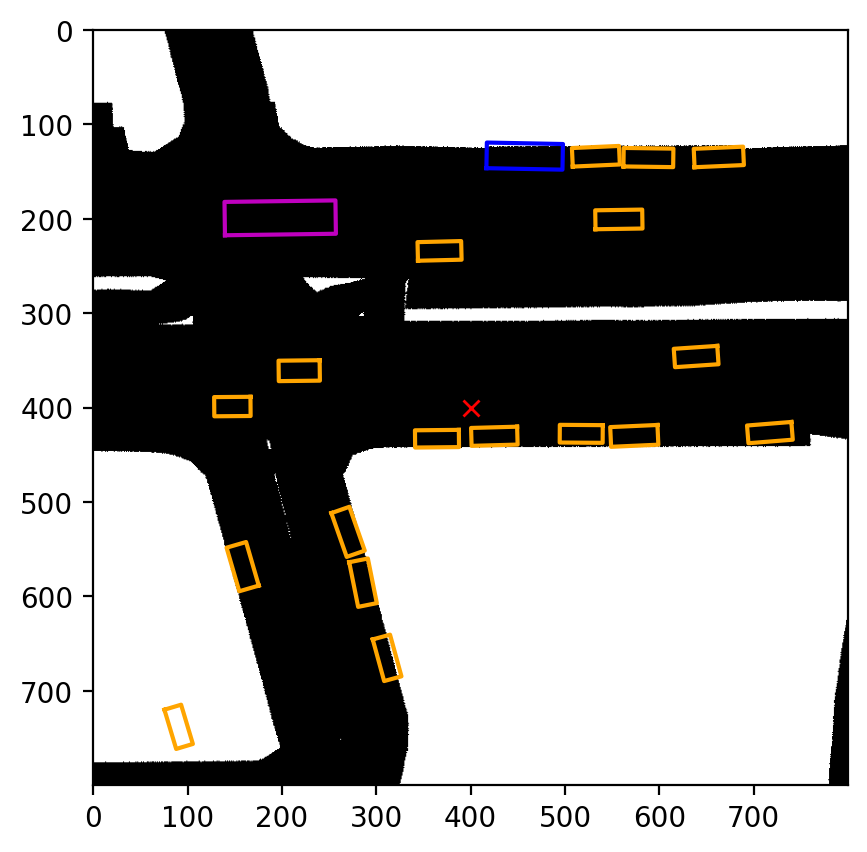

In [56]:
sample, target, road_image = iter(valloader).next()

fig, ax = plt.subplots()
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary');
# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])

In [0]:
model.eval()

BoundingBox(
  (encoder): ResNet(
    (conv1): Conv2d(18, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [0]:
s = torch.stack(sample).to('cpu').double()

out_pred, out_bbox = model(s)
class_target, box_target = get_targets(target, sample)

In [0]:
print(out_pred.shape)
print(out_bbox.shape)

print(class_target.shape)
print(box_target.shape)

torch.Size([1, 36, 800, 800])
torch.Size([1, 16, 800, 800])
torch.Size([1, 2560000])
torch.Size([1, 2560000, 4])


In [0]:
out_bbox = out_bbox.view(out_bbox.shape[0], -1, 4)

In [0]:
out_bbox.shape

torch.Size([1, 2560000, 4])

In [0]:
final_coor, batched_threat_sum = batched_coor_threat_updated(_, out_bbox, get_anchor_boxes(), [target[0]['bounding_box'].numpy()], class_target, 1, nms_threshold=0.1, plot=False)

RuntimeError: No such operator torchvision::nms

In [0]:
!python3 -m torch.utils.collect_env

PyTorch version: 1.5.0
Is debug build: No
CUDA used to build PyTorch: None

OS: Mac OSX 10.15.4
GCC version: Could not collect
CMake version: Could not collect

Python version: 3.7
Is CUDA available: No
CUDA runtime version: No CUDA
GPU models and configuration: No CUDA
Nvidia driver version: No CUDA
cuDNN version: No CUDA

Versions of relevant libraries:
[pip3] numpy==1.16.3
[pip3] torch==1.5.0
[pip3] torchvision==0.6.0
[conda] Could not collect
